In [30]:
import json
import cv2
import keras_tuner as kt
import numpy as np
import pandas as pd
import plotly.express as px
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

---
### Data Reading
---

In [15]:
data = np.load('../data/training_data.npz', allow_pickle=True)

train_set = data['train_set']
test_set = data['test_set']
val_set = data['val_set']

In [16]:
def resize_image(image, target_size):
    # Convert the image to 3 channels if it's not
    if len(image.shape) == 2:
        image = np.stack((image,)*3, axis=-1)
    # Resize the image
    resized_image = cv2.resize(image, target_size)
    return resized_image

In [17]:
def create_dataframe(set):
    df_ = pd.DataFrame([], columns=['x', 'y'])	
    for i in range(len(set)):
        df_ = pd.concat([df_, pd.DataFrame(
            {'reading': [resize_image(set[i]['x'], (32, 32))],
            'posture': set[i]['y']}
        )])
    return df_

In [18]:
df_train = create_dataframe(train_set)
df_test = create_dataframe(test_set)
df_val = create_dataframe(val_set)

print(df_train.shape, df_test.shape, df_val.shape)

(108, 4) (54, 4) (27, 4)


In [19]:
X_train = df_train['reading']
y_train = df_train['posture']
X_val = df_val['reading']
y_val = df_val['posture']
X_test = df_test['reading']
y_test = df_test['posture']
# One-hot encode the labels
y_train = pd.get_dummies(y_train).values
y_val = pd.get_dummies(y_val).values
y_test = pd.get_dummies(y_test).values

In [20]:
X_train = np.array([np.array(x) for x in X_train])
# X_train = np.expand_dims(X_train, -1)
X_val = np.array([np.array(x) for x in X_val])
# X_val = np.expand_dims(X_val, -1)
X_test = np.array([np.array(x) for x in X_test])
# X_test = np.expand_dims(X_test, -1)
y_train = np.array([np.array(x) for x in y_train])
y_test = np.array([np.array(x) for x in y_test])
y_val = np.array([np.array(x) for x in y_val])
# Convert the data to tensors
X_train = tf.convert_to_tensor(X_train)
X_val = tf.convert_to_tensor(X_val)
X_test = tf.convert_to_tensor(X_test)
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)
y_test = tf.convert_to_tensor(y_test)

---
### Model Definition
---

In [37]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(32, 32, 3)
)

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))

base_model.trainable = False

In [38]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    patience=5
)

In [39]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

---
### Model Training
---

In [40]:
hist = model.fit(
    X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100, callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
4/4 [==============================] - 2s 328ms/step - loss: 1.6482 - accuracy: 0.3426 - val_loss: 2.5882 - val_accuracy: 0.4074 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 1s 211ms/step - loss: 0.9395 - accuracy: 0.6389 - val_loss: 1.6874 - val_accuracy: 0.5926 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 1s 228ms/step - loss: 0.6333 - accuracy: 0.7500 - val_loss: 1.9319 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 1s 239ms/step - loss: 0.4426 - accuracy: 0.8333 - val_loss: 2.0978 - val_accuracy: 0.7407 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 1s 204ms/step - loss: 0.4047 - accuracy: 0.7963 - val_loss: 2.1068 - val_accuracy: 0.4815 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 1s 201ms/step - loss: 0.3202 - accuracy: 0.8889 - val_loss: 2.0643 - val_accuracy: 0.3704 - lr: 0.0010
Epoch 7/100
4/4 [==============================] - 1s 202ms/step - loss: 0.2

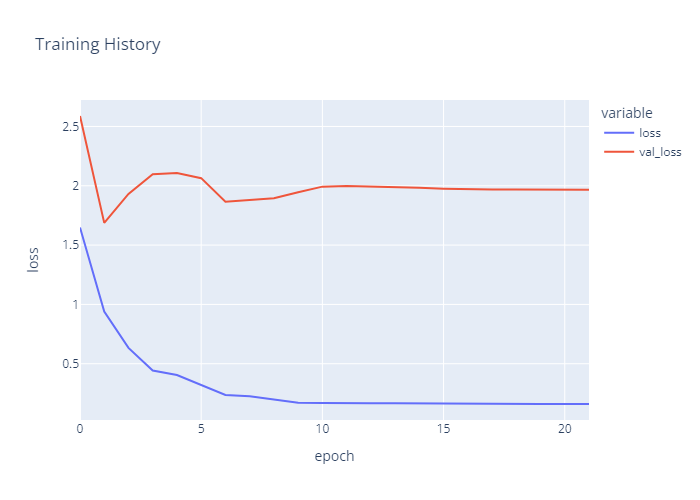

In [41]:
fig = px.line(
    hist.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History'
)
fig.show('png')

In [42]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 1s 155ms/step - loss: 1.3778 - accuracy: 0.5370


[1.377803087234497, 0.5370370149612427]

In [44]:
y_pred = model.predict(X_test)
pd.Series(y_pred.argmax(axis=1)).value_counts()

2/2 [==============================] - 0s 121ms/step


1    25
0    17
2    12
dtype: int64

In [46]:
model.save('vgg16_no_da.keras')